<a href="https://colab.research.google.com/github/CryptoRobotFr/easy_backtest/blob/main/Multi_Super_Reversal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Installation de package extérieurs**

In [ ]:
!pip install ccxt ta

### **Importations**

In [8]:
import asyncio
from posixpath import dirname
from pathlib import Path
import ccxt.async_support as ccxt
import pytz
import pandas as pd
import os
from datetime import timedelta
import datetime
from tqdm.auto import tqdm
import nest_asyncio
import numpy as np
import matplotlib.pyplot as plt
import ta
import seaborn as sns
import math
pd.options.mode.chained_assignment = None  # default='warn'

### **Définition de fonctions utilitaires**

In [33]:
nest_asyncio.apply()

awaitfn = lambda x: asyncio.get_event_loop().run_until_complete(x)

class ExchangeDataManager:

    # Liste des exchanges à supporter
    CCXT_EXCHANGES = {
        "binance": {
            "ccxt_object": ccxt.binance(config={'enableRateLimit': True}),
            "limit_size_request": 1000
        },
        "ftx": {
            "ccxt_object": ccxt.ftx(config={'enableRateLimit': True}),
            "limit_size_request": 5000
        },
        "kucoin": {
            "ccxt_object": ccxt.kucoin(config={'enableRateLimit': True}),
            "limit_size_request": 1500
        },
        "hitbtc": {
            "ccxt_object": ccxt.hitbtc(config={'enableRateLimit': True}),
            "limit_size_request": 1000
        },
        "bitfinex": {
            "ccxt_object": ccxt.bitfinex(config={'enableRateLimit': True}),
            "limit_size_request": 10000
        }
    }

    # Liste des intervalles à supporter
    INTERVALS = {
        "1m": {
            "timedelta": timedelta(minutes=1),
            "interval_ms": 60000
        },
        "2m": {
            "timedelta": timedelta(minutes=2),
            "interval_ms": 120000
        },
        "5m": {
            "timedelta": timedelta(minutes=5),
            "interval_ms": 300000
        },
        "15m": {
            "timedelta": timedelta(minutes=15),
            "interval_ms": 900000
        },
        "30m": {
            "timedelta": timedelta(minutes=30),
            "interval_ms": 1800000
        },
        "1h": {
            "timedelta": timedelta(hours=1),
            "interval_ms": 3600000
        },
        "2h": {
            "timedelta": timedelta(hours=2),
            "interval_ms": 7200000
        },
        "4h": {
            "timedelta": timedelta(hours=4),
            "interval_ms": 14400000
        },
        "12h": {
            "timedelta": timedelta(hours=12),
            "interval_ms": 43200000
        },
        "1d": {
            "timedelta": timedelta(days=1),
            "interval_ms": 86400000
        },
        "1w": {
            "timedelta": timedelta(weeks=1),
            "interval_ms": 604800000
        },
        "1M": {
            "timedelta": timedelta(days=30),
            "interval_ms": 2629746000
        }
    }

    def __init__(self, exchange_name, path_download="./") -> None:
        """La fonction prend une chaîne et si possible la convertit en objet ccxt.
        La fonction crée également un chemin vers un dossier appelé nommé dans le répertoire parent
        du répertoire courant, et crée un sous-dossier dans ce dossier avec le nom de l'échange.

        Args:
            cex (_type_): L'échange que vous souhaitez utiliser
            path_download (str, optional): Chemin du dossier à créer exemple ./database. Defaults to "./".

        Raises:
            NotImplementedError: Raise si l'exchange n'est pas paramétré/supporté
        """
        self.exchange_name = exchange_name.lower()
        self.path_download = path_download
        try:
            self.exchange_dict = ExchangeDataManager.CCXT_EXCHANGES[self.exchange_name]
        except Exception:
            raise NotImplementedError(
                f"L'échange {self.exchange_name} n'est pas supporté")
        self.intervals_dict = ExchangeDataManager.INTERVALS
        
        self.exchange = self.exchange_dict["ccxt_object"]

        self.path_data = str(
            Path(os.path.join(dirname("__file__"), self.path_download, self.exchange_name)).resolve())
        os.makedirs(self.path_data, exist_ok=True)
        self.pbar = None

    def load_data(self, coin, interval, start_date="1990", end_date="2050") -> pd.DataFrame:
        """
        Cette fonction prend une paire, un intervalle, une date de début et une date de fin et renvoie
        une trame de données des données OHLCV pour cette paire

        :param coin: la paire pour laquelle vous souhaitez obtenir des données
        :param interval: l'intervalle de temps entre chaque point de données
        :param start_date: La date de début des données que vous souhaitez charger
        :param end_date: La date à laquelle vous souhaitez mettre fin à vos données
        """
        file_path = f"{self.path_data}/{interval}/"
        file_name = f"{file_path}{coin.replace('/', '-')}.csv"
        if not os.path.exists(file_name):
            raise FileNotFoundError(f"Le fichier {file_name} n'existe pas")

        df = pd.read_csv(file_name, index_col=0, parse_dates=True)
        df.index = pd.to_datetime(df.index, unit='ms')
        df = df.groupby(df.index).first()
        df = df.loc[start_date:end_date]
        df = df.iloc[:-1]

        return df

    async def download_data(
        self,
        coins,
        intervals,
        start_date="2017-01-01 00:00:00",
        end_date=datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    ):
        """
        Télécharge les données des API de CEX et les stocke dans des fichiers csv

        :param coins: une liste de paires pour lesquelles télécharger des données
        :param intervals: liste de chaînes, par ex. ['1h', '1d', '5m']
        :param end_date: la date d'arrêt du téléchargement des données. Si aucun, téléchargera les
        données jusqu'à la date actuelle
        """

        start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
        end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")

        for interval in intervals:

            all_dt_intervals = list(self.create_intervals(
                start_date, end_date, self.create_timedelta(interval)))
            last_dt = all_dt_intervals[-1].astimezone(pytz.utc)

            end_timestamp = int(last_dt.timestamp() * 1000)

            for coin in coins:
                print(
                    f"\tRécupération pour la paire {coin} en timeframe {interval} sur l'exchange {self.exchange_name}...")

                file_path = f"{self.path_data}/{interval}/"
                os.makedirs(file_path, exist_ok=True)
                file_name = f"{file_path}{coin.replace('/', '-')}.csv"

                dt_or_false = await self.is_data_missing(file_name, last_dt)
                if dt_or_false:

                    # print("\tTéléchargement des données")

                    tasks = []
                    current_timestamp = int(dt_or_false.timestamp() * 1000)

                    while True:
                        tasks.append(asyncio.create_task(self.download_tf(
                            coin, interval, current_timestamp)))
                        current_timestamp = min([current_timestamp + self.exchange_dict["limit_size_request"] *
                                                 self.intervals_dict[interval]["interval_ms"], end_timestamp])
                        if current_timestamp >= end_timestamp:
                            break

                    self.pbar = tqdm(tasks)
                    results = await asyncio.gather(*tasks)
                    await self.exchange.close()
                    self.pbar.close()

                    all_df = []
                    for i in results:
                        # Si on n'a aucune donnée on ne fait rien
                        if i:
                            all_df.append(pd.DataFrame(i))

                    # Si il y a des données
                    if all_df:
                        final = pd.concat(all_df, ignore_index=True, sort=False)
                        final.columns = ['date', 'open',
                                         'high', 'low', 'close', 'volume']
                        final.rename(
                            columns={0: 'date', 1: 'open', 2: 'high', 3: 'low', 4: 'close', 5: 'volume'})
                        final.set_index('date', drop=False, inplace=True)
                        final = final[~final.index.duplicated(keep='first')]
                        if os.path.exists(file_name):
                            with open(file_name, mode='a') as f:
                                final.iloc[1:].to_csv(
                                    path_or_buf=f, header=False, index=False)
                        else:
                            with open(file_name, mode='w') as f:
                                final.to_csv(path_or_buf=f, index=False)
                    else:
                        print(
                            f"\tPas de données pour {coin} en {interval} sur cette période")
                else:
                    print("\tDonnées déjà récupérées")
                    
                print("\033[H\033[J", end="")

    async def download_tf(self, coin, interval, start_timestamp):
        """
        Télécharge les données de l'API et les stocke dans une trame de données.

        :param coin: la pièce pour laquelle vous souhaitez télécharger des données
        :param interval: l'intervalle de temps des données que vous souhaitez télécharger
        :param start_timestamp: l'heure de début des données que vous souhaitez télécharger
        """
        tests = 1
        while tests < 3:
            try:
                r = await self.exchange.fetch_ohlcv(
                    symbol=coin, timeframe=interval, since=start_timestamp, limit=self.exchange_dict["limit_size_request"])

                self.pbar.update(1)
                return r
            except Exception:
                tests += 1
                if tests == 3:
                    raise TooManyError

    async def is_data_missing(self, file_name, last_dt):
        """
        Cette fonction vérifie s'il y a des données manquantes dans la base de données pour une pièce,
        un intervalle et une plage de temps donnés

        :param file_name: Le nom du fichier pour vérifier les données manquantes
        :param coin: la pièce que vous voulez vérifier
        :param interval: l'intervalle des données, par ex. 1m, 5m, 1h, 1j
        :param start_timestamp: L'horodatage de début des données que vous souhaitez vérifier
        :param end_timestamp: L'horodatage du dernier point de données que vous souhaitez vérifier
        """
        # On check la première data dispo sur le CEX

        await self.exchange.close()

        if os.path.isfile(file_name):
            df = pd.read_csv(file_name, index_col=0, parse_dates=True)
            df.index = pd.to_datetime(df.index, unit='ms')
            df = df.groupby(df.index).first()

            if pytz.utc.localize(df.index[-1]) >= last_dt:
                return False
        else:
            # Le fichier n'existe pas, on renvoie la date de début
            return datetime.datetime.fromisoformat('2017-01-01')

        return pytz.utc.localize(df.index[-1])

    def create_intervals(self, start_date, end_date, delta):
        """
        Étant donné une date de début, une date de fin et un delta de temps, créez une liste de tuples
        de la forme (start_date, end_date) où chaque tuple représente un intervalle de temps de longueur
        delta

        :param start_date: La date de début de l'intervalle
        :param end_date: La date de fin de l'intervalle
        :param delta: un objet timedelta qui représente la longueur de l'intervalle
        """
        current = start_date
        while current <= end_date:
            yield current
            current += delta

    def create_timedelta(self, interval):
        """
        Retourne un timedelta en fonction de l'intervalle donné

        :param interval: L'intervalle de temps à utiliser dans timedelta
        """
        try:
            return self.intervals_dict[interval]["timedelta"]
        except Exception:
            raise ValueError(f"Intervalle {interval} inconnu")
        
    def explore_data(self): 
        files_data = []
        for path, subdirs, files in os.walk(self.path_download):
            for name in files:
                if os.path.join(path, name).endswith('.csv'):
                    current_file = os.path.join(path, name)
                    file_split = current_file.split("\\")
                    try:
                        df_file = pd.read_csv(current_file)
                    
                        

                        files_data.append({
                            "exchange": file_split[1],
                            "timeframe": file_split[2],
                            "coin": file_split[3][:-4],
                            "occurences": len(df_file),
                            "start_date": str(datetime.fromtimestamp(df_file.iloc[0]["date"]/1000)),
                            "end_date": str(datetime.fromtimestamp(df_file.iloc[-1]["date"]/1000))
                        })
                    except Exception:
                        continue
                    
        return pd.DataFrame(files_data)        

class TooManyError(Exception):
    pass

def basic_multi_asset_backtest(trades, days):
    df_trades = trades.copy()
    df_days = days.copy()
    
    df_days['evolution'] = df_days['wallet'].diff()
    df_days['daily_return'] = df_days['evolution']/df_days['wallet'].shift(1)
    
    
    df_trades = df_trades.copy()
    df_trades['trade_result'] = df_trades["close_trade_size"] - df_trades["open_trade_size"] - df_trades["open_fee"] - df_trades["close_fee"]
    df_trades['trade_result_pct'] = df_trades['trade_result']/(df_trades["open_trade_size"] + df_trades["open_fee"])
    good_trades = df_trades.loc[df_trades['trade_result_pct'] > 0]
    
    df_trades['wallet_ath'] = df_trades['wallet'].cummax()
    df_trades['drawdown'] = df_trades['wallet_ath'] - df_trades['wallet']
    df_trades['drawdown_pct'] = df_trades['drawdown'] / df_trades['wallet_ath']
    df_days['wallet_ath'] = df_days['wallet'].cummax()
    df_days['drawdown'] = df_days['wallet_ath'] - df_days['wallet']
    df_days['drawdown_pct'] = df_days['drawdown'] / df_days['wallet_ath']
    
    good_trades = df_trades.loc[df_trades['trade_result'] > 0]
    
    total_pair_traded = df_trades['pair'].nunique()
    initial_wallet = df_days.iloc[0]["wallet"]
    total_trades = len(df_trades)
    total_good_trades = len(good_trades)
    avg_profit = df_trades['trade_result_pct'].mean()   
    global_win_rate = total_good_trades / total_trades
    max_trades_drawdown = df_trades['drawdown_pct'].max()
    max_days_drawdown = df_days['drawdown_pct'].max()
    final_wallet = df_days.iloc[-1]['wallet']
    buy_and_hold_pct = (df_days.iloc[-1]['price'] - df_days.iloc[0]['price']) / df_days.iloc[0]['price']
    buy_and_hold_wallet = initial_wallet + initial_wallet * buy_and_hold_pct
    vs_hold_pct = (final_wallet - buy_and_hold_wallet)/buy_and_hold_wallet
    vs_usd_pct = (final_wallet - initial_wallet)/initial_wallet
    sharpe_ratio = (365**0.5)*(df_days['daily_return'].mean()/df_days['daily_return'].std())
    
    print("Period: [{}] -> [{}]".format(df_days.iloc[0]["day"], df_days.iloc[-1]["day"]))
    print("Initial wallet: {} $".format(round(initial_wallet,2)))
    print("Trades on {} pairs".format(total_pair_traded))
    
    print("\n--- General Information ---")
    print("Final wallet: {} $".format(round(final_wallet,2)))
    print("Performance vs US dollar: {} %".format(round(vs_usd_pct*100,2)))
    print("Sharpe Ratio: {}".format(round(sharpe_ratio,2)))
    print("Worst Drawdown T|D: -{}% | -{}%".format(round(max_trades_drawdown*100, 2), round(max_days_drawdown*100, 2)))
    print("Buy and hold performance: {} %".format(round(buy_and_hold_pct*100,2)))
    print("Performance vs buy and hold: {} %".format(round(vs_hold_pct*100,2)))
    print("Total trades on the period: {}".format(total_trades))
    print("Global Win rate: {} %".format(round(global_win_rate*100, 2)))
    print("Average Profit: {} %".format(round(avg_profit*100, 2)))
    
    print("\n----- Pair Result -----")
    print('-' * 95)
    print('{:<6s}{:>10s}{:>15s}{:>15s}{:>15s}{:>15s}{:>15s}'.format(
                "Trades","Pair","Sum-result","Mean-trade","Worst-trade","Best-trade","Win-rate"
                ))
    print('-' * 95)
    for pair in df_trades["pair"].unique():
        df_pair = df_trades.loc[df_trades["pair"] == pair]
        pair_total_trades = len(df_pair)
        pair_good_trades = len(df_pair.loc[df_pair["trade_result"] > 0])
        pair_worst_trade = str(round(df_pair["trade_result_pct"].min() * 100, 2))+' %'
        pair_best_trade = str(round(df_pair["trade_result_pct"].max() * 100, 2))+' %'
        pair_win_rate = str(round((pair_good_trades / pair_total_trades) * 100, 2))+' %'
        pair_sum_result = str(round(df_pair["trade_result_pct"].sum() * 100, 2))+' %'
        pair_avg_result = str(round(df_pair["trade_result_pct"].mean() * 100, 2))+' %'
        print('{:<6d}{:>10s}{:>15s}{:>15s}{:>15s}{:>15s}{:>15s}'.format(
                            pair_total_trades,pair,pair_sum_result,pair_avg_result,pair_worst_trade,pair_best_trade,pair_win_rate
                        ))
    
    return df_trades, df_days

def plot_sharpe_evolution(df_days):
    df_days_copy = df_days.copy()
    df_days_copy['evolution'] = df_days_copy['wallet'].diff()
    df_days_copy['daily_return'] = df_days_copy['evolution']/df_days_copy['wallet'].shift(1)

    df_days_copy['mean'] = df_days_copy['daily_return'].rolling(365).mean()
    df_days_copy['std'] = df_days_copy['daily_return'].rolling(365).std()
    df_days_copy['sharpe'] = (365**0.5)*(df_days_copy['mean']/df_days_copy['std'])
    df_days_copy['sharpe'].plot(figsize=(18, 9))

def plot_wallet_vs_asset(df_days):
    fig, axes = plt.subplots(figsize=(15, 12), nrows=2, ncols=1)
    df_days['wallet'].plot(ax=axes[0])
    df_days['price'].plot(ax=axes[1], color='orange')
    
def get_metrics(df_trades, df_days):
    df_days_copy = df_days.copy()
    df_days_copy['evolution'] = df_days_copy['wallet'].diff()
    df_days_copy['daily_return'] = df_days_copy['evolution']/df_days_copy['wallet'].shift(1)
    sharpe_ratio = (365**0.5)*(df_days_copy['daily_return'].mean()/df_days_copy['daily_return'].std())
    
    df_days_copy['wallet_ath'] = df_days_copy['wallet'].cummax()
    df_days_copy['drawdown'] = df_days_copy['wallet_ath'] - df_days_copy['wallet']
    df_days_copy['drawdown_pct'] = df_days_copy['drawdown'] / df_days_copy['wallet_ath']
    max_drawdown = -df_days_copy['drawdown_pct'].max() * 100
    
    df_trades_copy = df_trades.copy()
    df_trades_copy['trade_result'] = df_trades_copy["close_trade_size"] - df_trades_copy["open_trade_size"] - df_trades_copy["open_fee"] - df_trades_copy["close_fee"]
    df_trades_copy['trade_result_pct'] = df_trades_copy['trade_result']/df_trades_copy["open_trade_size"]
    good_trades = df_trades_copy.loc[df_trades_copy['trade_result_pct'] > 0]
    win_rate = len(good_trades) / len(df_trades)
    avg_profit = df_trades_copy['trade_result_pct'].mean()
    
    return {
        "sharpe_ratio": sharpe_ratio,
        "win_rate": win_rate,
        "avg_profit": avg_profit,
        "total_trades": len(df_trades_copy),
        "max_drawdown": max_drawdown
    }
    
def get_n_columns(df, columns, n=1):
    dt = df.copy()
    for col in columns:
        dt["n"+str(n)+"_"+col] = dt[col].shift(n)
    return dt

def plot_bar_by_month(df_days):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    custom_palette = {}
    
    last_month = int(df_days.iloc[-1]['day'].month)
    last_year = int(df_days.iloc[-1]['day'].year)
    
    current_month = int(df_days.iloc[0]['day'].month)
    current_year = int(df_days.iloc[0]['day'].year)
    current_year_array = []
    while current_year != last_year or current_month-1 != last_month:
        date_string = str(current_year) + "-" + str(current_month)
        
        monthly_perf = (df_days.loc[date_string]['wallet'].iloc[-1] - df_days.loc[date_string]['wallet'].iloc[0]) / df_days.loc[date_string]['wallet'].iloc[0]
        monthly_row = {
            'date': str(datetime.date(1900, current_month, 1).strftime('%B')),
            'result': round(monthly_perf*100)
        }
        if monthly_row["result"] >= 0:
            custom_palette[str(datetime.date(1900, current_month, 1).strftime('%B'))] = 'g'
        else:
            custom_palette[str(datetime.date(1900, current_month, 1).strftime('%B'))] = 'r'
        current_year_array.append(monthly_row)
        # print(monthly_perf*100) 
        if ((current_month == 12) or (current_month == last_month and current_year == last_year)):
            current_df = pd.DataFrame(current_year_array)
            # print(current_df)
            g = sns.barplot(data=current_df,x='date',y='result', palette=custom_palette)
            for index, row in current_df.iterrows():
                if row.result >= 0:
                    g.text(row.name,row.result, '+'+str(round(row.result))+'%', color='black', ha="center", va="bottom")
                else:
                    g.text(row.name,row.result, '-'+str(round(row.result))+'%', color='black', ha="center", va="top")
            g.set_title(str(current_year) + ' performance in %')
            g.set(xlabel=current_year, ylabel='performance %')
            
            year_result = (df_days.loc[str(current_year)]['wallet'].iloc[-1] - df_days.loc[str(current_year)]['wallet'].iloc[0]) / df_days.loc[str(current_year)]['wallet'].iloc[0]
            print("----- " + str(current_year) +" Cumulative Performances: " + str(round(year_result*100,2)) + "% -----")
            plt.show()

            current_year_array = []
        
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1

class SuperTrend():
    def __init__(
        self,
        high,
        low,
        close,
        atr_window=10,
        atr_multi=3
    ):
        self.high = high
        self.low = low
        self.close = close
        self.atr_window = atr_window
        self.atr_multi = atr_multi
        self._run()
        
    def _run(self):
        # calculate ATR
        price_diffs = [self.high - self.low, 
                    self.high - self.close.shift(), 
                    self.close.shift() - self.low]
        true_range = pd.concat(price_diffs, axis=1)
        true_range = true_range.abs().max(axis=1)
        # default ATR calculation in supertrend indicator
        atr = true_range.ewm(alpha=1/self.atr_window,min_periods=self.atr_window).mean() 
        # atr = ta.volatility.average_true_range(high, low, close, atr_period)
        # df['atr'] = df['tr'].rolling(atr_period).mean()
        
        # HL2 is simply the average of high and low prices
        hl2 = (self.high + self.low) / 2
        # upperband and lowerband calculation
        # notice that final bands are set to be equal to the respective bands
        final_upperband = upperband = hl2 + (self.atr_multi * atr)
        final_lowerband = lowerband = hl2 - (self.atr_multi * atr)
        
        # initialize Supertrend column to True
        supertrend = [True] * len(self.close)
        
        for i in range(1, len(self.close)):
            curr, prev = i, i-1
            
            # if current close price crosses above upperband
            if self.close[curr] > final_upperband[prev]:
                supertrend[curr] = True
            # if current close price crosses below lowerband
            elif self.close[curr] < final_lowerband[prev]:
                supertrend[curr] = False
            # else, the trend continues
            else:
                supertrend[curr] = supertrend[prev]
                
                # adjustment to the final bands
                if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                    final_lowerband[curr] = final_lowerband[prev]
                if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                    final_upperband[curr] = final_upperband[prev]

            # to remove bands according to the trend direction
            if supertrend[curr] == True:
                final_upperband[curr] = np.nan
            else:
                final_lowerband[curr] = np.nan
                
        self.st = pd.DataFrame({
            'Supertrend': supertrend,
            'Final Lowerband': final_lowerband,
            'Final Upperband': final_upperband
        })
        
    def super_trend_upper(self):
        return self.st['Final Upperband']
        
    def super_trend_lower(self):
        return self.st['Final Lowerband']
        
    def super_trend_direction(self):
        return self.st['Supertrend']


# Classe a potentiellement modifié si l'on veut modifier la stratégie
class super_reversion_strat():
    def __init__(
        self,
        df_list,
        oldest_pair,
        parameters_obj
    ):
        self.df_list = df_list
        self.oldest_pair = oldest_pair
        self.parameters_obj = parameters_obj
        
    def populate_indicators(self, show_log=False):
        # -- Clear dataset --
        for pair in self.df_list:
            df = self.df_list[pair]
            params = self.parameters_obj[pair]
            df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
            
            # -- Populate indicators --
            super_trend = SuperTrend(
                df['high'], 
                df['low'], 
                df['close'], 
                params["st_short_atr_window"], 
                params["st_short_atr_multiplier"]
            )
            
            df['super_trend_direction'] = super_trend.super_trend_direction()
            df['ema_short'] = ta.trend.ema_indicator(close=df['close'], window=params["short_ema_window"])
            df['ema_long'] = ta.trend.ema_indicator(close=df['close'], window=params["long_ema_window"])
            
            df = get_n_columns(df, ["super_trend_direction", "ema_short", "ema_long"], 1)
            
            self.df_list[pair] = df
            # -- Log --
            if(show_log):
                print(self.df_list[self.oldest_pair])
                
        return self.df_list[self.oldest_pair]
    
    def populate_buy_sell(self, show_log=False): 
        data_open_long = []
        data_close_long = []

        for pair in self.df_list:
            params = self.parameters_obj[pair]
            df = self.df_list[pair]
            # -- Initiate populate --
            df["open_long_limit"] = False
            df["close_long_limit"] = False
            df["pair"] = pair
            df["null"] = np.nan
            
            # -- Populate open long limit --
            df.loc[
                (df['n1_ema_short'] >= df['n1_ema_long']) 
                & (df['n1_super_trend_direction'] == True) 
                & (df['n1_ema_short'] > df['low']) 
                , "open_long_limit"
            ] = True
            
            # -- Populate close long limit --
            df.loc[
                ((df['n1_ema_short'] <= df['n1_ema_long'])
                | (df['n1_super_trend_direction'] == False))
                & (df['n1_ema_short'] < df['high'])
                , "close_long_limit"
            ] = True
                
            # -- Populate pair list per date (do not touch)--
            data_open_long.append(
                df.loc[
                (df['open_long_limit']  == True) 
                ]['pair']
            )
            data_close_long.append(
                df.loc[
                (df['close_long_limit']  == True) 
                ]['pair']
            )

        data_open_long.append(self.df_list[self.oldest_pair]['null'])
        data_close_long.append(self.df_list[self.oldest_pair]['null'])
        df_open_long = pd.concat(data_open_long, axis=1)
        df_open_long['combined']= df_open_long.values.tolist()
        df_open_long['combined'] = [[i for i in j if i == i] for j in list(df_open_long['combined'])]
        df_close_long = pd.concat(data_close_long, axis=1)
        df_close_long['combined']= df_close_long.values.tolist()
        df_close_long['combined'] = [[i for i in j if i == i] for j in list(df_close_long['combined'])]
        self.open_long_obj = df_open_long['combined']
        self.close_long_obj = df_close_long['combined']
        
        # -- Log --
        if(show_log):
            print("Open LONG length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["open_long"]==True]))
            print("Close LONG length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["close_long"]==True]))
        
        return self.df_list[self.oldest_pair]
    
    def run_backtest(self, initial_wallet=1000, return_type="metrics"):
        df_ini = self.df_list[self.oldest_pair][:]
        wallet = initial_wallet
        usd_remaining = initial_wallet
        usd_pct_remaining = 1
        maker_fee = 0
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_positions = {}
        
        for index, row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                for pos in current_positions:
                    actual_row = self.df_list[pos].loc[index]
                    close_price = actual_row['close']
                    trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']
                    close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                    fee = close_size * taker_fee
                    temp_wallet += close_size - current_positions[pos]['size'] - fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day 
            
            # Sell
            close_long_row = self.close_long_obj.loc[index]
            if len(current_positions) > 0:
                position_to_close = set(current_positions).intersection(set(close_long_row))
                for pos in position_to_close:
                    actual_row = self.df_list[pos].loc[index]
                    close_price = actual_row['n1_ema_short']
                    trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']
                    close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                    fee = close_size * maker_fee
                    wallet += close_size - current_positions[pos]['size'] - fee
                    usd_remaining += close_size - fee
                    usd_pct_remaining += self.parameters_obj[pos]['wallet_exposure']
                    trades.append({
                        "pair": pos,
                        "open_date": current_positions[pos]['date'],
                        "close_date": index,
                        "position": current_positions[pos]['side'],
                        "open_reason": current_positions[pos]['reason'],
                        "close_reason": "Market",
                        "open_price": current_positions[pos]['price'],
                        "close_price": close_price,
                        "open_fee": current_positions[pos]['fee'],
                        "close_fee": fee,
                        "open_trade_size":current_positions[pos]['size'],
                        "close_trade_size":close_size,
                        "wallet": wallet,
                        "usd_remaining": usd_remaining
                    })
                    del current_positions[pos]   
                    
            # Buy
            open_long_row = self.open_long_obj.loc[index]
            if len(open_long_row) > 0:
                for pos in open_long_row:
                    if pos not in current_positions:
                        actual_row = self.df_list[pos].loc[index]
                        open_price = actual_row['n1_ema_short']
                        pos_size = usd_remaining * (self.parameters_obj[pos]['wallet_exposure'] / usd_pct_remaining)
                        usd_pct_remaining -= self.parameters_obj[pos]['wallet_exposure']
                        fee = pos_size * maker_fee
                        pos_size -= fee
                        wallet -= fee
                        usd_remaining -= pos_size+fee
                        current_positions[pos] = {
                            "size": pos_size,
                            "date": index,
                            "price": open_price,
                            "fee":fee,
                            "reason": "Market",
                            "side": "LONG"
                        }
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        if return_type == "metrics":
            return {**get_metrics(df_trades, df_days), **{
                "wallet": wallet,
                "trades": df_trades,
                "days": df_days
            }  }
        else:
            return True



### **Backtest**

--- Récupération des données ---

In [31]:
# ----- Paramètre à potentiellement modifier ------
# Attention somme des wallet exposure doit être inférieur ou égale à 1
params_coin = {
    "BTC/USDT": {
        "wallet_exposure": 0.3,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 10,
        "long_ema_window": 400
    },
    "ETH/USDT": {
        "wallet_exposure": 0.1,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 10,
        "long_ema_window": 400
    },
    "LTC/USDT": {
        "wallet_exposure": 0.2,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 5,
        "long_ema_window": 400
    },
    "SOL/USDT": {
        "wallet_exposure": 0.2,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 40,
        "long_ema_window": 400
    },
    "LUNA/USDT": {
        "wallet_exposure": 0.2,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 15,
        "long_ema_window": 400
    },
}

tf = '1h'
oldest_pair = "BTC/USDT"
exchange = ExchangeDataManager(exchange_name="binance", path_download="./database")

# ----- Fin des paramètres à modifier ------

pair_list = list(params_coin.keys())
awaitfn(exchange.download_data(coins=pair_list, intervals=[tf]))

df_list = {}
for pair in pair_list:
    df = exchange.load_data(coin=pair, interval=tf)
    df_list[pair] = df.loc[:]

print("Data loaded 100%")
df_list[oldest_pair]



	Récupération pour la paire BTC/USDT en timeframe 1h sur l'exchange binance...
	Données déjà récupérées
	Récupération pour la paire ETH/USDT en timeframe 1h sur l'exchange binance...
	Données déjà récupérées
	Récupération pour la paire LTC/USDT en timeframe 1h sur l'exchange binance...
	Données déjà récupérées
	Récupération pour la paire SOL/USDT en timeframe 1h sur l'exchange binance...
	Données déjà récupérées
	Récupération pour la paire LUNA/USDT en timeframe 1h sur l'exchange binance...
	Données déjà récupérées
Data loaded 100%


,open,high,low,close,volume
date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2022-04-29 03:00:00,39522.12,39557.87,39286.01,39533.01,1777.885240
2022-04-29 04:00:00,39533.02,39598.30,39368.97,39542.94,1436.131490
2022-04-29 05:00:00,39542.94,39641.30,39481.45,39501.26,1154.069130


--- Éxécution du backtest et analyses ---

Period: [2017-08-17 00:00:00] -> [2022-04-29 00:00:00]
Initial wallet: 1000.0 $
Trades on 5 pairs

--- General Information ---
Final wallet: 57037.06 $
Performance vs US dollar: 5603.71 %
Sharpe Ratio: 2.41
Worst Drawdown T|D: -14.76% | -18.05%
Buy and hold performance: 824.73 %
Performance vs buy and hold: 516.8 %
Total trades on the period: 607
Global Win rate: 35.58 %
Average Profit: 4.08 %

----- Pair Result -----
-----------------------------------------------------------------------------------------------
Trades      Pair     Sum-result     Mean-trade    Worst-trade     Best-trade       Win-rate
-----------------------------------------------------------------------------------------------
153     BTC/USDT       351.12 %         2.29 %       -13.04 %        40.52 %        37.91 %
181     ETH/USDT       470.35 %          2.6 %        -11.9 %        84.33 %        32.04 %
150     LTC/USDT       397.02 %         2.65 %       -10.37 %        61.17 %        32.67 %
47      SOL/USDT  

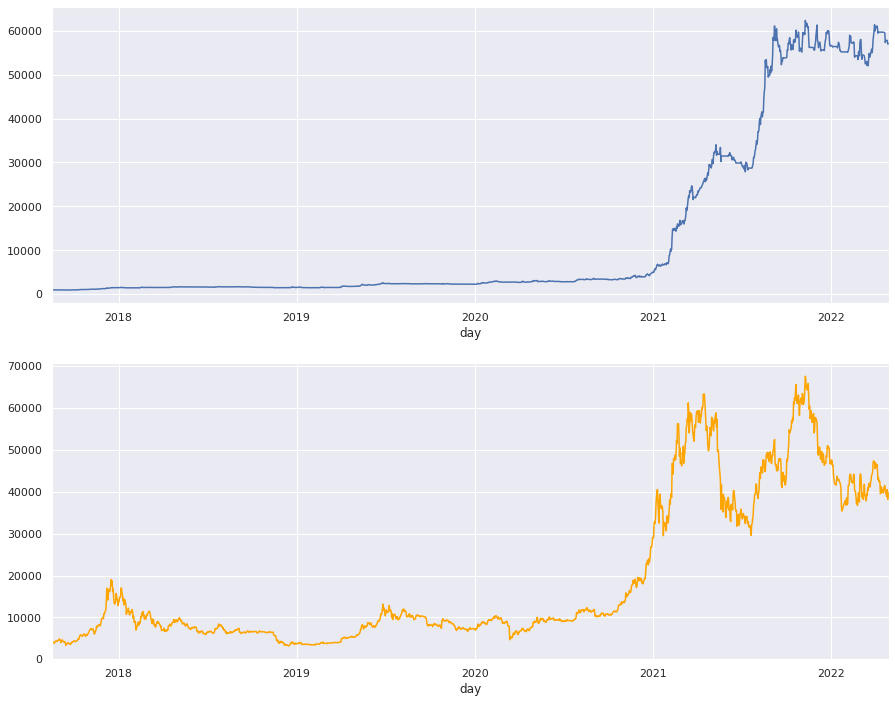

In [32]:
strat = super_reversion_strat(
    df_list=df_list,
    oldest_pair=oldest_pair,
    parameters_obj=params_coin
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")

df_trades, df_days = basic_multi_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=df_days)

--- Graphiques des performances ---

----- 2017 Cumulative Performances: 48.57% -----


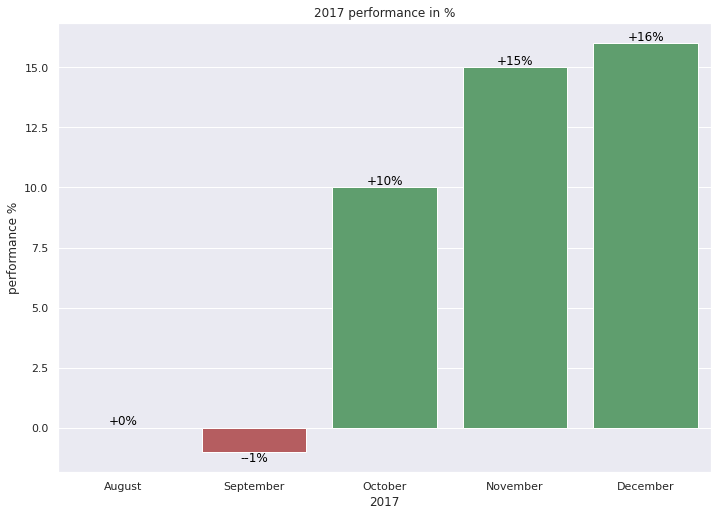

----- 2018 Cumulative Performances: 5.38% -----


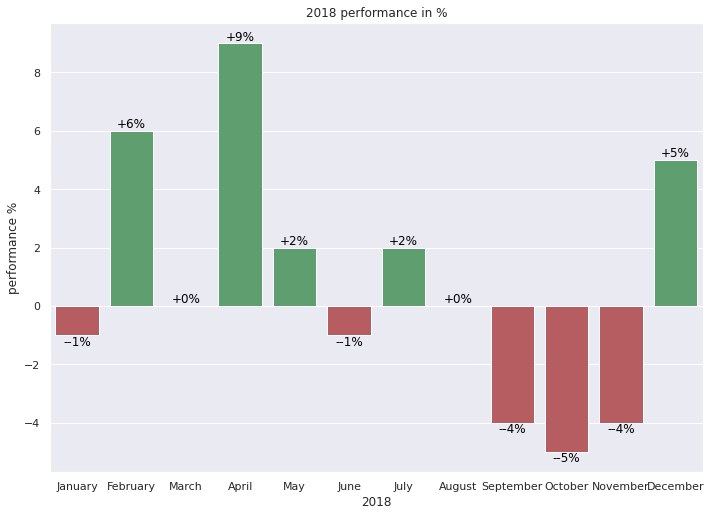

----- 2019 Cumulative Performances: 49.01% -----


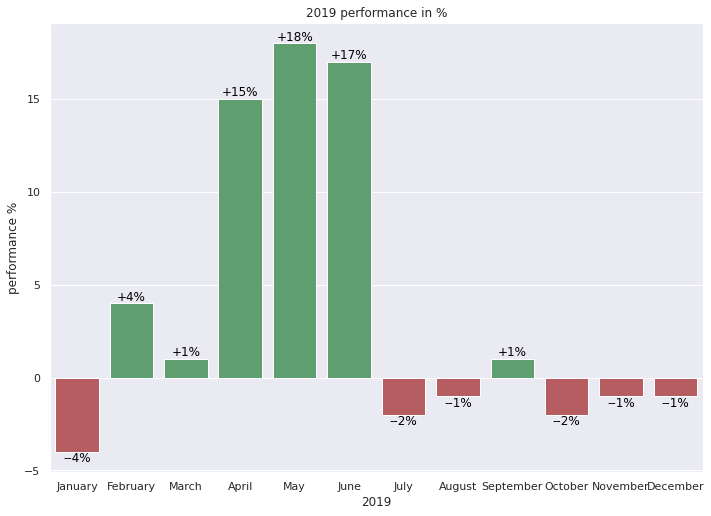

----- 2020 Cumulative Performances: 119.3% -----


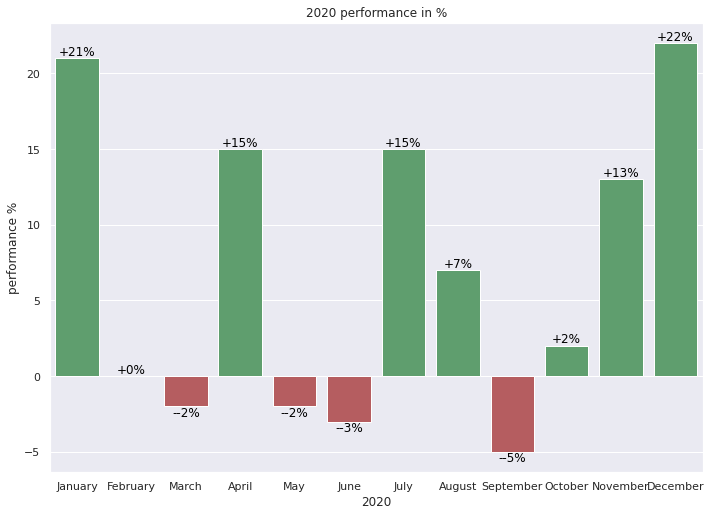

----- 2021 Cumulative Performances: 1036.34% -----


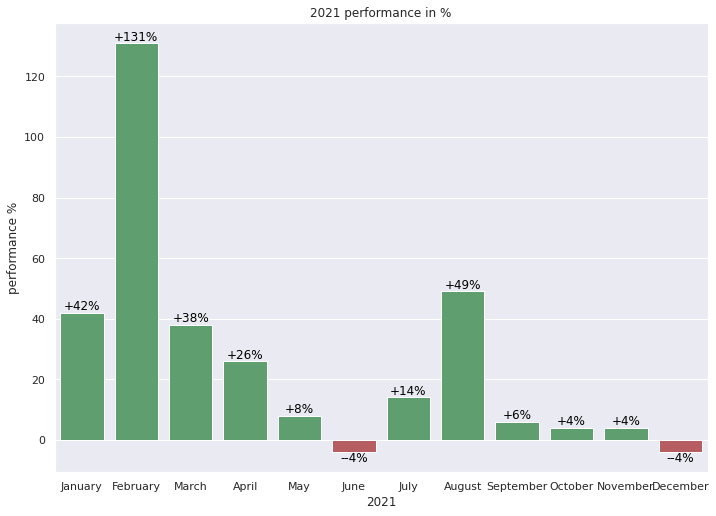

----- 2022 Cumulative Performances: 0.73% -----


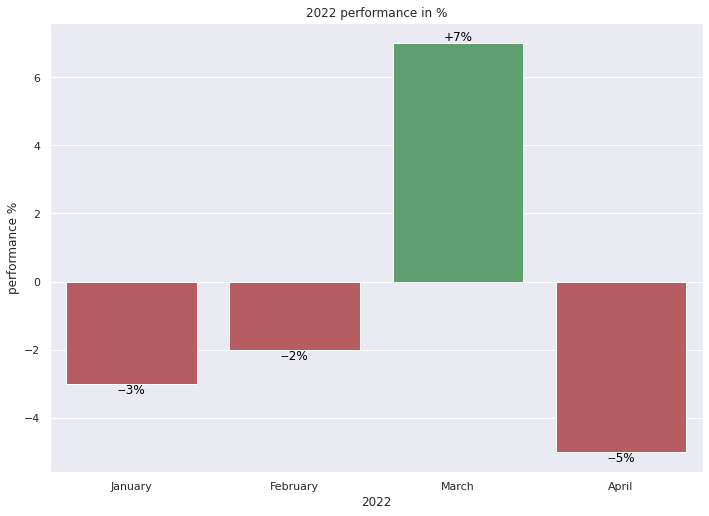

In [24]:
plot_bar_by_month(df_days=df_days)